# Метод глубокой перекрестной энтропии

В этом разделе мы расширим вашу реализацию CEM с помощью нейронных сетей! Вы научите многослойную нейронную сеть решать простые задачи с непрерывным пространством состояний. Пожалуйста, убедитесь, что вы закончили использовать метод трубчатой перекрестной энтропии из предыдущей книги

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [31]:
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')
!pip install "gymnasium[toy_text,classic_control]" > /dev/null

Keyring is skipped due to an exception: 'keyring.backends'


In [32]:
import os
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.neural_network import MLPClassifier
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
%matplotlib inline

In [33]:
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 4
n_actions = 2


/opt/conda/envs/deeplearning/lib/python3.7/site-packages/gymnasium/envs/registration.py:524: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {env_name} is out of date. You should consider "


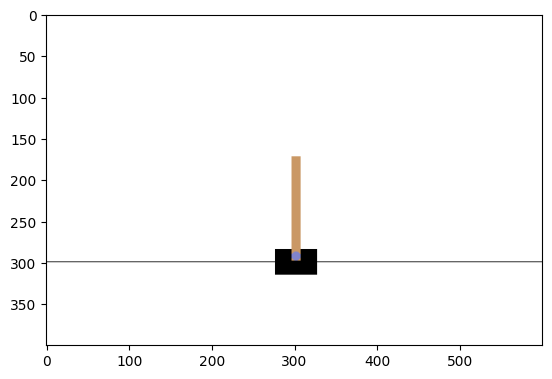

In [34]:
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Политика нейронной сети

Для этого задания мы будем использовать упрощенную реализацию нейронной сети из __ [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Вот что вам понадобится:

* `agent.partial_fit(состояния, действия)` - выполняет однократный тренировочный проход по данным. Увеличивает вероятность :действий: из :состояний:
* `agent.predict_proba(состояния)` - предсказывает вероятности всех действий, используя матрицу вида __[len(состояния), n_actions]__


In [35]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [36]:
def generate_session(env, agent, t_max=1000):
    """
    Сыграйте в одиночную игру, используя агентную нейронную сеть.
    Завершите игру, когда она закончится, или после :t_max: шагов
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        a = np.random.choice(np.arange(env.action_space.n), p=probs)
        new_s, r, terminated, truncated, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [37]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.03288447 -0.04587032 -0.03022695 -0.02953144]
 [-0.03380187  0.14967176 -0.03081757 -0.33159596]
 [-0.03080844 -0.04499827 -0.03744949 -0.04878848]
 [-0.0317084  -0.23956378 -0.03842526  0.23184757]
 [-0.03649968 -0.4341162  -0.03378831  0.51216656]]
actions: [1, 0, 0, 0, 0]
reward: 5.0


### Шаги CEM
В Deep CEM используется точно такая же стратегия, как и в обычной игре, поэтому вы можете скопировать свой функциональный код из предыдущего notebook.

Единственное отличие заключается в том, что теперь каждое наблюдение представляет собой не число, а вектор с плавающей точкой 32.

In [38]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Выберите состояния и действия из игр, в которых есть награды >= процентиль
    :параметр states_batch: список списков состояний, states_batch[session_i][t]
    :параметр actions_batch: список списков действий, actions_batch[session_i][t]
    :параметр rewards_batch: список вознаграждений, rewards_batch[session_i]

    :возвращает: elite_states,elite_actions, как одномерные списки состояний, так и соответствующие действия из элитных сессий

    Пожалуйста, верните элитные состояния и действия в их первоначальном порядке
    [[т.е. отсортированные по номеру сессии и временному шагу в рамках сессии]

    Если вы в замешательстве, посмотрите примеры ниже. Пожалуйста, не думайте, что состояния являются целыми числами
    (позже они станут другими).
    """
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states += states_batch[i]
            elite_actions += actions_batch[i]
    return elite_states, elite_actions


# Цикл обучения
Генерируйте сеансы, выбирайте N наилучших и подходящих для них.

In [39]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Удобная функция, отображающая прогресс в тренировках.
    Здесь нет классной математики, только графики.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 205.850, threshold=242.900


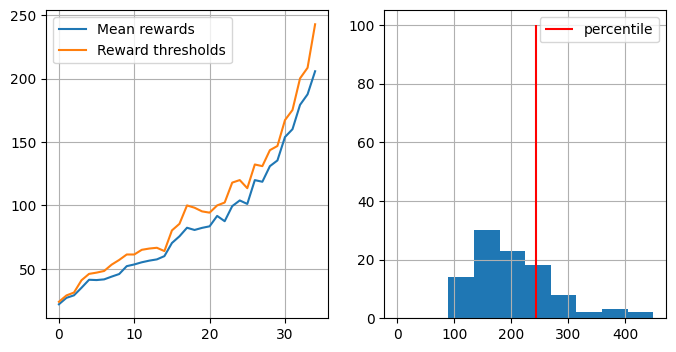

Вы выиграли!
CPU times: user 30.2 s, sys: 7.04 s, total: 37.3 s
Wall time: 29.6 s


In [40]:
%%time
n_sessions = 100
percentile = 70
log = []
for i in range(100):
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent.partial_fit(elite_states, elite_actions)
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
    if np.mean(rewards_batch) > 190:
        print("Вы выиграли!")
        break

# Результаты

In [41]:
with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="video",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(1)]


/opt/conda/envs/deeplearning/lib/python3.7/site-packages/gymnasium/envs/registration.py:524: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {env_name} is out of date. You should consider "
/opt/conda/envs/deeplearning/lib/python3.7/site-packages/gymnasium/wrappers/record_video.py:88: UserWarning: WARN: Overwriting existing videos at /notebooks/week01_intro/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


Moviepy - Building video /notebooks/week01_intro/video/rl-video-episode-0.mp4.
Moviepy - Writing video /notebooks/week01_intro/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/week01_intro/video/rl-video-episode-0.mp4


In [42]:
# Показать видео. В некоторых настройках это может не сработать. Если этого не произойдет
# работаем на вас, вы можете загружать видео и просматривать их локально.
video_paths = sorted([s for s in Path("video").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Домашнее задание, часть I

### ### Метод трубчатой перекрестной энтропии

Возможно, вы заметили, что задача о такси быстро достигает значения от -100 до почти оптимального, а затем возвращается к значению -50/-100. Отчасти это объясняется тем, что окружающая среда обладает некоторой врожденной хаотичностью. А именно, начальные точки взаимодействия пассажира и водителя меняются от эпизода к эпизоду.

### Задачи
- __1.1__ (2 пункта) Узнайте, как изменится производительность алгоритма, если вы используете другой "процентиль" и/или "n_sessions". Приведите здесь несколько цифр, чтобы мы могли увидеть, как гиперпараметры влияют на производительность.
- __1.2__ (1 балл) Настройте алгоритм так, чтобы в итоге получить положительный средний балл.

Можно изменить существующий код.

```<Describe what you did here>```

# Домашнее задание, часть II

### Метод глубокой кроссэнтропии

К этому моменту вы должны набрать достаточное количество баллов по [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/), чтобы считать его решенным (смотрите ссылку). Пришло время попробовать что-нибудь посложнее.

* если у вас возникнут какие-либо проблемы с CartPole-v0 и вы почувствуете, что застряли, не стесняйтесь обращаться за помощью к нам или своим коллегам.

### Задачи

* __2.1__ (3 очка) Выберите одну из сред: "Маунтинк-кар-v0" или "ЛунарЛендер-v2".
  * За Маунтинк-кар получите среднее вознаграждение в размере __не менее -150__
  * За лунного жителя получите среднюю награду в размере не менее +50__

Ознакомьтесь с разделом советов ниже, это очень важно.
__ Примечание:__ Если ваш агент набрал меньше целевого балла, вы все равно получите часть баллов в зависимости от результата, так что не бойтесь подавать заявку.
  
  
* __2.2__ (до 6 пунктов) Разработать способ ускорить обучение по сравнению с версией по умолчанию
  * Очевидное улучшение: используйте [`joblib`](https://joblib.readthedocs.io/en/latest/). Однако обратите внимание, что вам, вероятно, потребуется создать новую среду в каждом из рабочих объектов вместо того, чтобы передавать ее через травление. (2 очка)
  * Попробуйте повторно использовать выборки из 3-5 последних итераций при вычислении порога и обучении. (2 балла)
  * Получите __-100__ в "MountainCar-v0` или __+200__ в `LunarLander-v2` (2 балла). Не стесняйтесь экспериментировать с гиперпараметрами, архитектурой, графиками и т.д.
  
__ Пожалуйста, укажите, что вы сделали, в форме отправки любого задания. Это снижает вероятность того, что кто-то что-то пропустит.
  
  
### Советы
* Страницы спортзала: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Сеансы для MountainCar могут длиться более 10 тысяч тактов. Убедитесь, что параметр `t_max` имеет значение не менее 10 тысяч.
 * Также, возможно, было бы неплохо сократить количество вознаграждений с помощью ">", а не ">=". Если 90% ваших сессий получают вознаграждение в размере -10 тысяч, а 10% - это лучше, чем если бы вы использовали процентиль 20% в качестве порогового значения, R >= threshold __ не сможет отсечь плохие сессии, в то время как R > threshold работает нормально.
* "проблема с тренажерным залом": в некоторых версиях gym время игры ограничено на 200 секунд. В большинстве случаев это предотвратит тренировку cem. Убедитесь, что ваш агент может играть в течение указанного времени, и если это не так, попробуйте `env = gym.make("MountainCar-v0").env` или иным образом удалите оболочку для ограничения времени.
* Если вы используете старую _swig_ lib для LunarLander-v2, может возникнуть ошибка. Решение проблемы смотрите в этой статье(https://github.com/openai/gym/issues/100).
* Если это не помогает, неплохо бы составить график распределения вознаграждений и записать занятия: возможно, это даст вам какую-то подсказку. Если это не помогает, позвоните сотрудникам курса :)
* Сети из 20 нейронов, вероятно, недостаточно, не стесняйтесь экспериментировать.

Возможно, следующий фрагмент будет вам полезен:

/opt/conda/envs/deeplearning/lib/python3.7/site-packages/gymnasium/envs/registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  f"The environment is being initialised with render_mode={render_mode!r} "


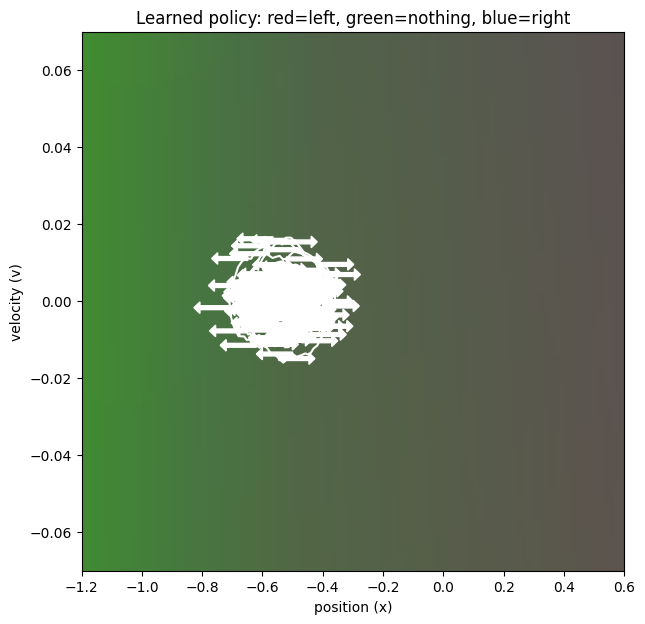

In [43]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)

X_train = np.random.rand(1000, 2)  # Позиция и скорость
y_train = np.random.randint(0, 3, size=1000)  # Действия: {0, 1, 2}

agent = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
agent.fit(X_train, y_train)
with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)


### Бонусные задания

* __* __2.3 бонусные задания (2 балла) Попытайтесь найти сетевую архитектуру и параметры обучения, которые решают обе указанные выше задачи (баллы зависят от реализации. Если вы пытались выполнить это задание, пожалуйста, укажите это при отправке любого задания._)

* __2.4 бонус__ (4 балла) Решите задачу continuous action space с помощью `MLPRegressor` или аналогичного.
  * Поскольку ваш агент предсказывает только "ожидаемое" действие, вам придется добавить шума, чтобы обеспечить разведку.
  * Выберите один из [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (более 90 пунктов для решения), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander /) (`env = gym.make("LunarLander-v2", continuous=True)") (нужно решить более 200 задач)
  * 4 балла за решение. Немного меньше за получение результатов ниже порога решения. Обратите внимание, что в дискретной и непрерывной средах могут быть немного разные правила, помимо пространств действий.